In [1]:
import sys
print(sys.version)
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

import pandas as pd
import numpy as np
import math

import random
import matplotlib.pyplot as plt
%matplotlib inline


3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
2.8.0
2.8.0


In [2]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_14768\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### batch_shape = (N of time series in a batch, the length of time series, N of features)
Example: training batch_shape = (10, 32, 3), where there are 10 total time series, each ts has 32 input time points, and there are 3 input features/vars for the ts

create period-10 sin wave with 500 cycles
In total, the sin wave time series length is 5001


<AxesSubplot:title={'center':'Generated first 8 cycles'}>

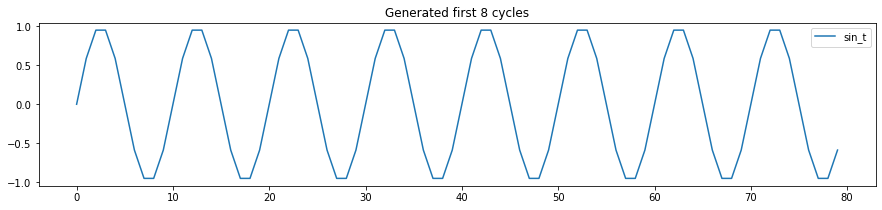

In [3]:
# Generate sine wave with no noise
def noisy_sin(steps_per_cycle = 50,
              number_of_cycles = 500,
              random_factor = 0.4):
    '''
    random_factor    : amont of noise in sign wave. 0 = no noise
    number_of_cycles : The number of steps required for one cycle (default 500)
    
    Return : 
    pd.DataFrame() with column sin_t containing the generated sin wave 
    '''
    random.seed(0)
    df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
    df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
    df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
    print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
    print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
    return(df)



steps_per_cycle = 10
df = noisy_sin(steps_per_cycle=steps_per_cycle,
              random_factor = 0)

n_plot = 8
df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
      title="Generated first {} cycles".format(n_plot),
      figsize=(15,3))


In [4]:
print(df)

         t         sin_t   sin_t_clean
0        0  0.000000e+00  0.000000e+00
1        1  5.877853e-01  5.877853e-01
2        2  9.510565e-01  9.510565e-01
3        3  9.510565e-01  9.510565e-01
4        4  5.877853e-01  5.877853e-01
...    ...           ...           ...
4996  4996 -5.877853e-01 -5.877853e-01
4997  4997 -9.510565e-01 -9.510565e-01
4998  4998 -9.510565e-01 -9.510565e-01
4999  4999 -5.877853e-01 -5.877853e-01
5000  5000 -3.214166e-13 -3.214166e-13

[5001 rows x 3 columns]


In [6]:
# Create a training and testing data. Here, the controversial "length of time series" parameter comes into play. For now, we set this parameter to 2.

def _load_data(data, n_prev = 100):
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].values)
        docY.append(data.iloc[i+n_prev].values)
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

length_of_sequences = 2      # 0th, 1st as input, 2nd is label, and so on
test_size = 0.25
ntr = int(len(df) * (1 - test_size))
df_train = df[["sin_t"]].iloc[:ntr]
df_test  = df[["sin_t"]].iloc[ntr:]
(X_train, y_train) = _load_data(df_train, n_prev = length_of_sequences)
(X_test, y_test)   = _load_data(df_test, n_prev = length_of_sequences)  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(3748, 2, 1) (3748, 1) (1249, 2, 1) (1249, 1)


#### RNN model
1. Simple RNN layer contains 3 weights: 1 weight for input, 1 weight for hidden unit, 1 weight for bias:  $h_t=tanh(x_t^Tw_{1x}+h^T_{t−1}w_{1h}+b_1)$
2. fully connected layer (dense) contains 2 weights: 1 weight for input (i.e., the output from the previous RNN layer), 1 weight for bias:  $x_{t+1}=h^T_tw_2+b_2$
3. So, the model has 5 weights in total (see #params in model summary)
4. The model remembers the past history of $x_t$ through hidden unit $h_t$
5. Every time when the model weights are updated, the BPTT uses only the randomly selected subset of the data. Each batch is treated as independent. This batch_shape determines the size of this subset
6. As we specify the length of the time series to be 2 (seq length), our model only knows about the past 2 sin wave values to predict the next sin wave value.
7. practical limitation of the finite length (2) of the time series defeats the theoretical beauty of RNN: the RNN here is not a model remembeing infinite past sequence
8. Note stateful=False and batch_size=None in the model. If stateful=True, it must have a fixed batch_size

In [7]:
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN



def define_model(length_of_sequences, batch_size = None, stateful = False):
    in_out_neurons = 1
    hidden_neurons = 1
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  

    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)

    dens = Dense(in_out_neurons,name="dense")(rnn)
    model = Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    
    return(model,(inp,rnn,dens))
## use the default values for batch_size, stateful
model, (inp,rnn,dens) = define_model(length_of_sequences = X_train.shape[1])  # length of seq = 2 (every 2 input time points to 1 output label)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 RNN (SimpleRNN)             (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist = model.fit(X_train, y_train, batch_size=600, epochs=1000, 
                 verbose=False,validation_split=0.05)

<IPython.core.display.Javascript object>


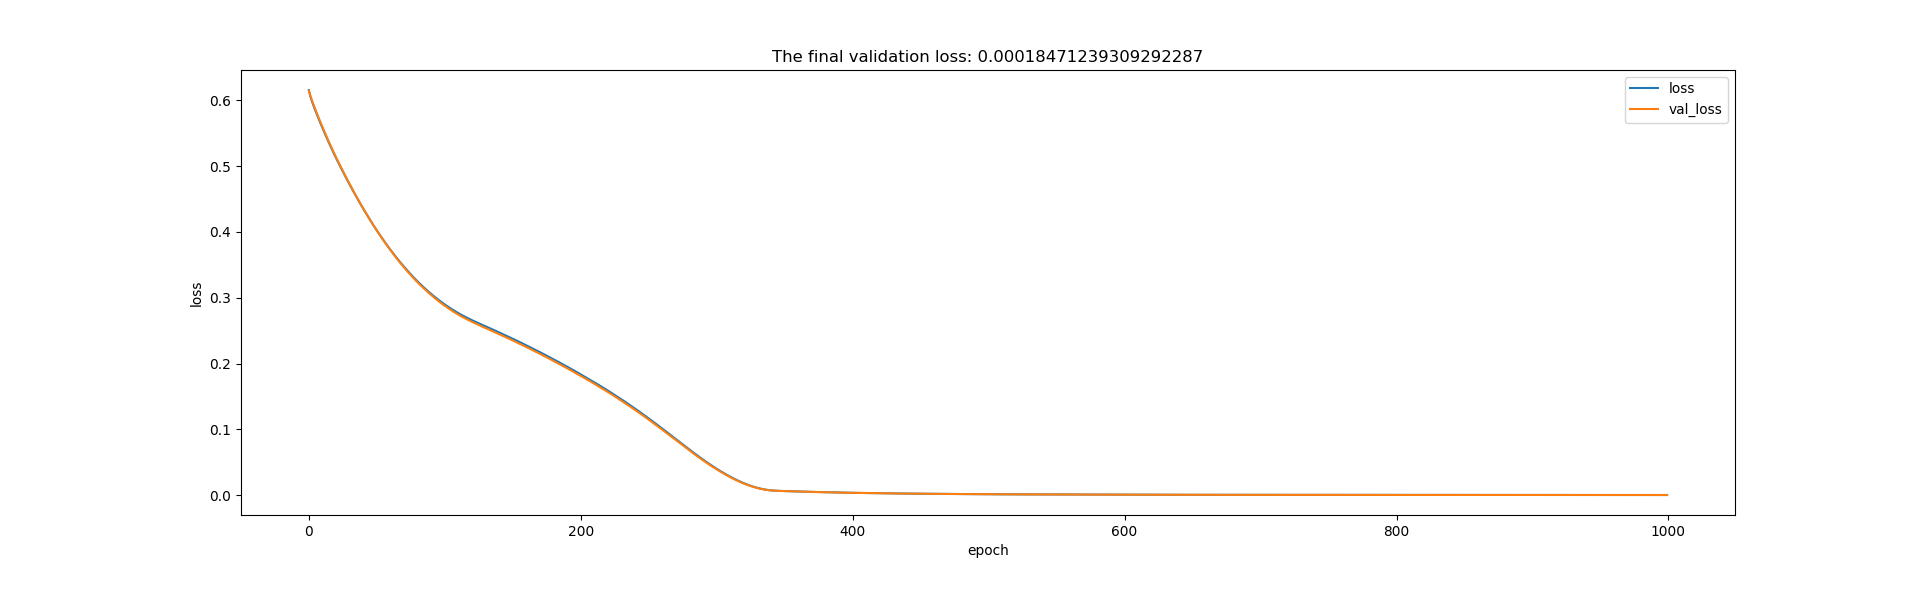

In [11]:
%matplotlib notebook
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


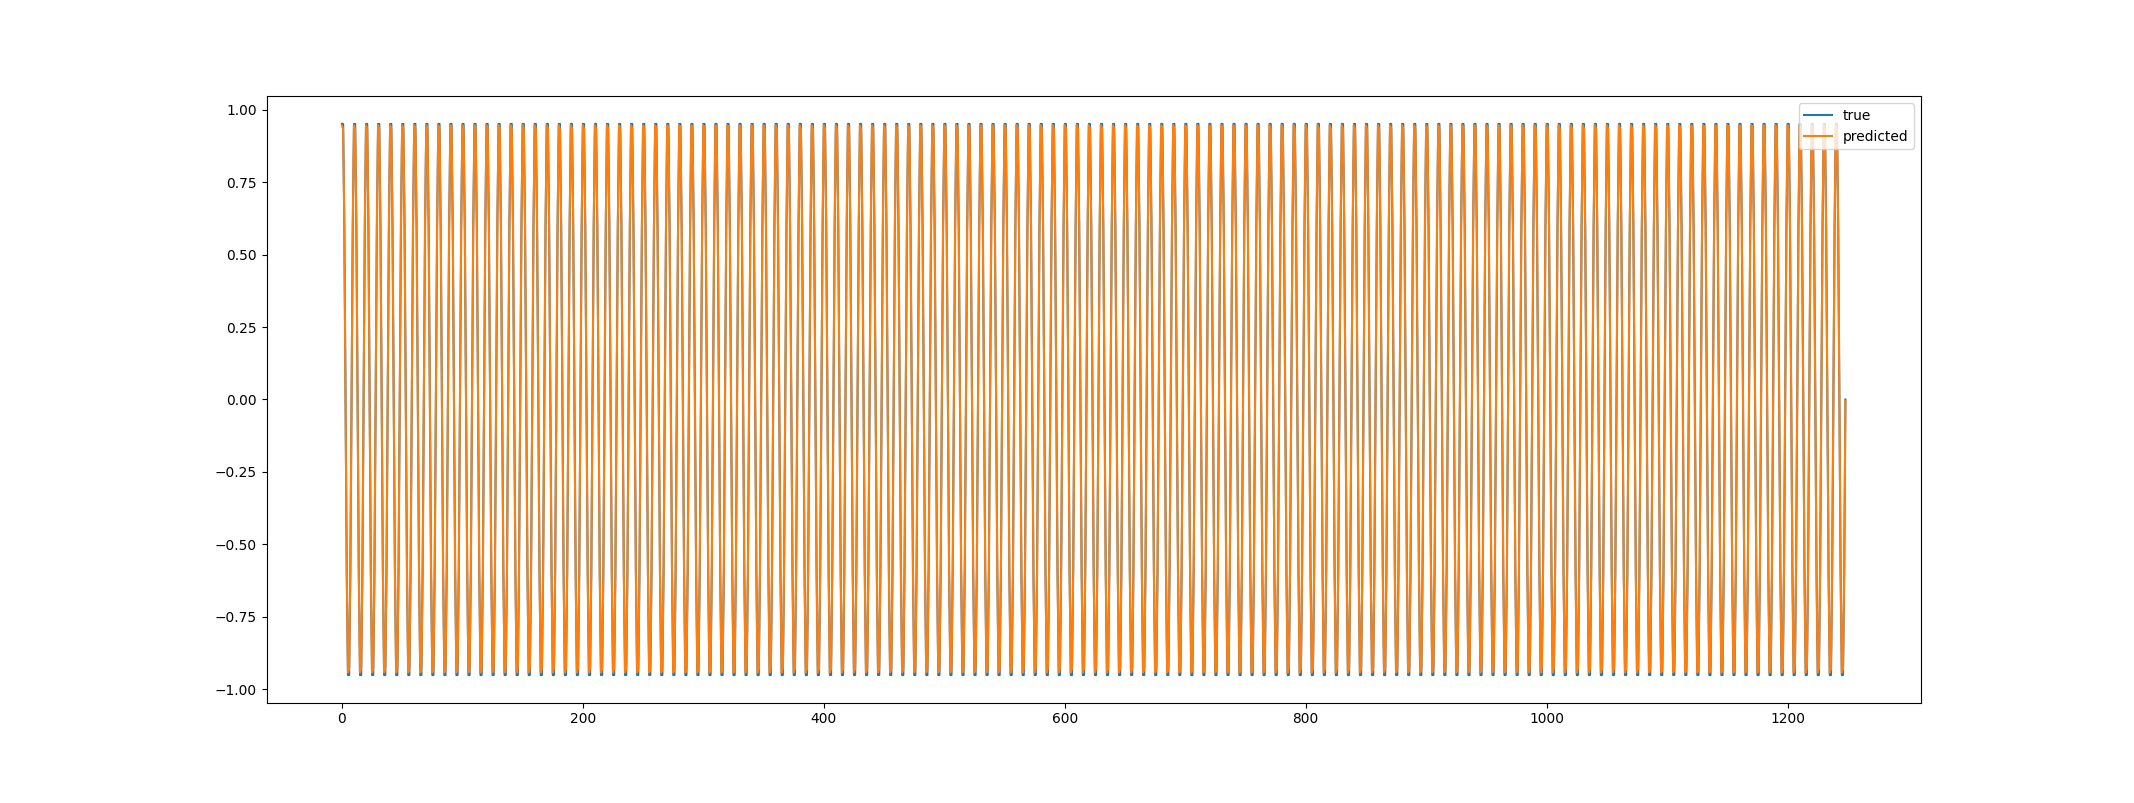

In [12]:
y_pred = model.predict(X_test)
plt.figure(figsize=(19,3))

plt.plot(y_test,label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()

In [14]:
# Extract the weights and try to reproduce the predicted values from the model by hands
ws = {}
for layer in model.layers:
    ws[layer.name] = layer.get_weights()
print(ws) # note 5 weights

{'input_1': [], 'RNN': [array([[0.4202396]], dtype=float32), array([[-0.64575124]], dtype=float32), array([0.00092639], dtype=float32)], 'dense': [array([[3.9010427]], dtype=float32), array([0.00085048], dtype=float32)]}


#### predict using weights
we do not actually optimize this loss function. The newly created model "rnn_model" shares the weights obtained by the previous model's optimization

In [15]:
rnn_model = Model(inputs=[inp],outputs=[rnn])
rnn_model.compile(loss="mean_squared_error", optimizer="rmsprop")
hidden_units = rnn_model.predict(X_test).flatten()

<IPython.core.display.Javascript object>


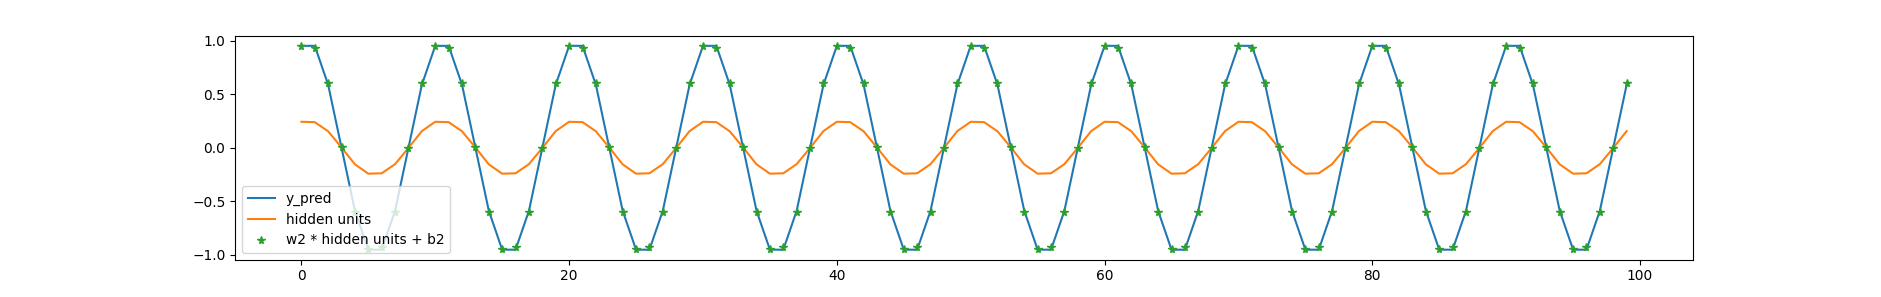

In [16]:
upto = 100
predicted_sin_wave = ws["dense"][0][0][0]*hidden_units + ws["dense"][1][0]

plt.figure(figsize=(19,3))
plt.plot(y_test[:upto],label="y_pred")
plt.plot(hidden_units[:upto],label="hidden units")
plt.plot(predicted_sin_wave[:upto],"*",
         label="w2 * hidden units + b2")
plt.legend()
plt.show()
